In [5]:
import pandas as pd

df_papers = pd.read_csv("all_papers.csv")
df_authors = pd.read_csv("all_authors.csv")
df_paper_abstracts = pd.read_csv("all_paper_abstracts.csv")


,Unnamed: 0.1,Unnamed: 0,id,title,year,doi,citations,fields,authors
0,0,0,644ca7ada31caf3e199593bb8470ce20d2dabd3e,Early Invasive Strategy Based on the Time of S...,2023.0,10.1016/j.jcin.2022.09.039,1,['Medicine'],"['151426488', '4239844', '8600251', '46455074'..."
1,1,1,9be790c557637b052dc6fd12987882367762752a,Real-World Comparison of Transcatheter Versus ...,2023.0,10.3390/jcm12020571,0,['Medicine'],"['4464665', '40035744', '5338844', '1661034763..."
2,2,2,05e33b6aca9192f2f3264b58641af78db14c66fb,TCTAP A-046 Prognostic Impact of Plasma Glucos...,2022.0,10.1016/j.jacc.2022.03.067,0,['Medicine'],"['83981515', '12570303', '2028271750', '143766..."
3,3,3,08372786639958bf8c2f0225fc4890727a51487e,Association between High Lipid Burden of Targe...,2022.0,10.3390/jcm11185401,0,"['Medicine', 'Biology']","['8600251', '4239844', '4929815', '46455074', ..."
4,4,4,087b373f7a41d7000b05a54fcda0e8caed5b3f83,ASSOCIATION OF PROPHYLACTIC DISTAL PERFUSION C...,2022.0,10.1016/s0735-1097(22)01240-2,0,['Medicine'],"['1576164887', '2975466', '46374746', '2773622..."


In [3]:
df_papers = df.drop_duplicates("id")

In [4]:
len(df_new)

1905194

# Assignment 1

# Formalia:

Please read the [assignment overview page](https://laura.alessandretti.com/comsocsci2023/assignments.html) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Feb 28th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Assignment, Assignment 1)_. 

Remember to include in the first cell of your notebook:
* the link to your group's Git repository (if you don't have a shared Git repository, it's fine. Remember to do it next time)
* group members' contributions

## Part 1: Using web-scraping to gather data

Gather the list of researchers that have joined the most important scientific conference in Computational Social Science in 2019. 

You can find the programmes of the 2019 edition at the links below:  
>Oral presentations: https://2019.ic2s2.org/oral-presentations/    
> Poster presentations: https://2019.ic2s2.org/posters/    

1. Inspect the HTML of the pages above and use web-scraping to get the set of participants in 2019. Share your code and add comments to guide us through it.
2. How many unique researchers you got in 2019?
3. Explain one or two decisions you took during the web-scraping exercise, for 2019 or any other year. Why did you take this choice? How might your decision impact the final number of authors?

We decided to extract the names from the poster session with regular expressions. Regular expressions are great tools for extracting text when there is a consistent format in the text. While the format is not completely consistent, we deemed it good enough to proceed. 

The oral presentations were less consistent than the poster session and so we chose to put our background in machine learning to use and chose to find the names with named entity recognition (NER) by using the very simple Huggingface pipeline tool. The advantage of NER is that very little pre/post-processing is needed but the disadvantage is that it's a black box model, so we cannot guarantee that it will find all the names.

While manual inspection of the data would have guaranteed that all names are correct, we chose not to do so as this rarely is a possibility when working with large datasets. Additionally, we don't think that this is check is necessary as the semantic scholar api will notify us if a name is not found.

In [1]:
import requests
from bs4 import BeautifulSoup
from bs4.element import NavigableString
import re
import transformers

# 2019 posters
speakers_2019 = set()
poster_pattern = re.compile(r"(?<=<li>)(.*?)(?=<span>|<br\/>|<\/li>)") # Regex to find properly segment li's
strong = re.compile(r"(<strong>|</strong>)")

poster_session = requests.get("https://2019.ic2s2.org/posters/").content
poster = BeautifulSoup(poster_session)

uls = poster.find_all("ul")[6:8] # The 7th and 8th uls are the elements containing the list of names and presentations

for ul in uls:
    for li in ul:
        if type(li) == NavigableString:
            continue
        match = re.findall(poster_pattern, str(li))
        if match: # if there was a match proceed
            if re.findall(strong, str(match)): # Filter away poorly written list elements (looking at you title in its own li)
                continue
            speakers = match[0].split(", ") # split names at ", "
            split = speakers[-1].split(" and ") # split the last potential pair of names at " and ", if there isn't a pair nothing happens
            if len(split) == 2: # if there was a pair of names it will be split
                speakers = speakers[:-1] + split
            for speaker in speakers:
                speakers_2019.add(speaker) # finally add the names from the li to the set of speakers

c:\Users\victo\Anaconda3\envs\si\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 2019 oral
url_2019_oral = "https://2019.ic2s2.org/oral-presentations/"
page_2019_oral = requests.get(url_2019_oral)
soup_2019_oral = BeautifulSoup(page_2019_oral.content)
paragraphs_2019_oral = soup_2019_oral.find_all("p")[3:-8]
texts_2019_oral = []
# get all the text where names are present.
for p in paragraphs_2019_oral:
    p = [i.get_text() for i in p]
    p = [i for i in p if len(i) > 0]
    for line in p:
        texts_2019_oral.append(line)

In [3]:
# A huggingface pipeline
pipe = transformers.pipeline("ner", aggregation_strategy="simple")

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [9]:
# simple post processing to make sure that we only get names
def get_names_from_ner(ner: list[dict]):
    "expects the ner to only contain a single full name i.e. first and last name. A middle name is optional"
    ner = [i for i in ner if i["entity_group"] == "PER"]
    ner = [i["word"] for i in ner]
    names = set()

    for name in ner:
        if len(name.split()) > 1 and "#" not in name:
            names.add(name)
    return names


In [5]:
ners_2019_oral = [pipe(i) for i in texts_2019_oral]

In [10]:
all_names = speakers_2019
names_2019_oral = [get_names_from_ner(i) for i in ners_2019_oral]
for names in names_2019_oral:
    all_names = all_names.union(set(names))

In [15]:
print(f"Number of unique names found: {len(all_names)}")

Number of unique names found: 903


## Part 2: Getting data from the Semantic Scholar API

> * Consider the list of author ids you have found in Week 2, Part 3, first excercise. For each author, use the Academic Graph API to find:
>    - their _aliases_
>    - their _name_
>    - their _papers_, where for each paper we want to retain: 
>        -  _title_ 
>        -  _abstract_ 
>        -  the _year_ of publication
>        -  the _externalIds_ (this is because there are universal identifiers for scientific works called DOI that we can use across platforms)
>        -  _s2FieldsOfStudy_ the fields of study
>        - _citationCount_ the number of times that this paper was cited    
> * Create three dataframe to store the data you have collected. 
>    
>    - **Author dataset:** in the author dataset, one raw is one unique author, and each row contains the following information: 
>        - *authorId*: (str) the id of the author
>        - *name*: (str) the name of the author
>        - *aliases*: (list) the aliases of the author
>        - *citationCount*: (int) the total number of citations received by an author
>        - *field*: (str) the _s2FieldsOfStudy_ that occurs most times across an author's papers (you should first obtain the *category* for each _s2FieldsOfStudy_)
>    - **Paper dataset:** in the paper dataset, one row is one unique paper, and each row contains the following information:
>        - *paperId*: (str) the id of the paper
>        - *title*: (str) the title of the paper
>        - *year*: (int) the year of publication
>        - *externalId.DOI:* (str) the DOI of the paper
>        - *citationCount*: (int) the number of citations
>        - *fields*: (list) the fields included in the paper (you should first obtain the *category* for each _s2FieldsOfStudy_)
>        - *authorIds:* (list) this is a list of *author Ids*, including all the authors of this paper that are in our author dataset
>    - **Paper abstract dataset:** in the paper abstract dataset, one row is one unique paper, and each row contains the following information: 
>        - *paperId*: (str) the id of the paper
>        - *abstract*: (str) the abstract of the paper    
>  (Note: we keep the abstract separate to keep the size of files more manageable)


1. Share the number of authors you will use as starting point in this exercises. Add a comment clarifying how many IC2S2 editions you included and if the collaborators were included or not.
2. Share the code you have used to solve the exercise above.
3. How long is your final _Author_ dataframe? How long is your final _Paper_ dataframe? 

(**Note**: If you did not manage to get all the years or all the authors' collaborators, you can still follow the exercise. Just remember to clarify your starting point.)



We used the authors from the 2019 oral and poster session, 2020, and 2021. We included all the collaborators and ended up with a total of 118,197 authors.
We then set up the code to make all the author requests in batches of 30 and planned on doing 40,000 authors each. When we had done about 15,000 authors each, we already had more than 4 GB of data and loading the data became very slow. The paper csv was so large that Excel could no longer open the csv.

So we decided to stop the program as we would not be able to hand the amount of data we would receive had we used all the authors. Since we used authors from the start, middle, and end of our list of authors, we likely have every year represented.

When combining the data, our authors data frame had a total of 29,147 rows, and our two paper dataframes had 1,905,194 rows each after removing duplicates.

In [1]:
import numpy as np
from time import sleep
import pandas as pd
import requests
import os
import pickle
from tqdm.notebook import tqdm

In [2]:
# utility functions for extracting data out of the responses
def get_citation_count(papers: list) -> int:
    citations = 0
    for paper in papers:
        citations += paper["citationCount"]
    return citations

def get_primary_field(papers: list) -> str:
    fields = {}
    for paper in papers:
        fields_of_study = paper["s2FieldsOfStudy"]
        for field in fields_of_study:
            category = field["category"]
            if category not in fields:
                fields[category] = 1
            else:
                fields[category] += 1
    return max(fields, key=fields.get) if len(fields) > 0 else None

def get_paper_author_ids(paper: dict) -> list:
    return [a["authorId"] for a in paper["authors"]]

In [3]:
# load the set of ids
with open("ids.pkl", "rb") as f:
    ids = list(pickle.load(f))
    print(len(ids))

118197


In [4]:
# make the requests and save periodically to separate files
def make_author_requests(ids: list[str], start_index: int = 0, end_index: int = 100_000, batch_size=30, save_threshold=500):
    if save_threshold < batch_size:
        print("save_threshold must be higher than batch_size")
        exit()
    batch_url = "https://api.semanticscholar.org/graph/v1/author/batch"
    responses = []
    requests_made = 0
    counter = start_index
    errors = []
    save_increment = int(np.ceil(save_threshold/batch_size) * batch_size)
    save_target = save_increment
    save_start_idx = 0
    while counter < end_index:
        current_ids = ids[counter: counter + batch_size]
        data = {"ids": current_ids}
        params = {"fields": "aliases,papers.title,papers.year,papers.externalIds,papers.s2FieldsOfStudy,papers.citationCount,papers.abstract,name,papers.authors"}
        try:
            response = requests.post(batch_url, json=data, params=params).json()
            
            if isinstance(response, dict):
                errors.append(response)
                if response["message"] == "Too Many Requests":
                    sleep(300)
                else:
                    counter += batch_size
            else:
                responses.append(response)
                counter += batch_size
                requests_made += batch_size
                if requests_made == save_target:
                    with open(f"responses_{save_start_idx+start_index}_{save_target+start_index}.pkl", "wb") as f:
                        pickle.dump(responses, f)
                    responses = []
                    save_start_idx = save_target
                    save_target += save_increment
        except Exception as e:
            print(e)
            counter += batch_size
            requests_made += batch_size
            if requests_made == save_target:
                with open(f"responses_{save_start_idx+start_index}_{save_target+start_index}.pkl", "wb") as f:
                    pickle.dump(responses, f)
                responses = []
                save_start_idx = save_target
                save_target += save_increment

    
    
    with open(f"responses_{save_start_idx+start_index}_{end_index+start_index}.pkl", "wb") as f:
        pickle.dump(responses, f)
    return errors

In [5]:
# possible api responses:
# {'message': 'Too Many Requests'}
# {'message': 'Endpoint request timed out'}
# {'message': 'Internal server error'}

In [6]:
def make_dfs():
    author_ids = []
    author_names = []
    all_author_aliases = []
    citation_counts_author = []
    fields = []
    paper_ids = []
    titles = []
    years = []
    dois = []
    citation_counts_paper = []
    all_fields = []
    all_author_ids = []
    abstracts = []       

    response_file_names = [i for i in os.listdir() if "responses" in i]

    for response_file in response_file_names:
        with open(response_file, "rb") as f:
            responses = pickle.load(f)
        print(response_file)
        for response in responses:
            for author_info in response: 
                if author_info is not None:
                    author_names.append(author_info["name"])
                    author_ids.append(author_info["authorId"])
                    all_author_aliases.append(author_info["aliases"])
                    citation_counts_author.append(get_citation_count(author_info["papers"]))
                    fields.append(get_primary_field(author_info["papers"]))
                    for paper in author_info["papers"]:
                        paper_ids.append(paper["paperId"])
                        titles.append(paper["title"])
                        years.append(paper["year"])
                        if "DOI" in paper["externalIds"]:
                            dois.append(paper["externalIds"]["DOI"])
                        else:
                            dois.append("None")
                        all_fields.append([field["category"] for field in paper["s2FieldsOfStudy"]])
                        all_author_ids.append(get_paper_author_ids(paper))
                        abstracts.append(paper["abstract"])
                        citation_counts_paper.append(paper["citationCount"])
            
    author_dict = {}
    author_dict["id"] = author_ids
    author_dict["name"] = author_names
    author_dict["aliases"] = all_author_aliases
    author_dict["citation_count"] = citation_counts_author
    author_dict["field"] = fields

    df_authors = pd.DataFrame(author_dict)
    df_authors.to_csv("authors.csv")

    paper_dict = {}
    paper_dict["id"] = paper_ids
    paper_dict["title"] = titles
    paper_dict["year"] = years
    paper_dict["doi"] = dois
    paper_dict["citations"] = citation_counts_paper
    paper_dict["fields"] = all_fields
    paper_dict["authors"] = all_author_ids

    df_papers = pd.DataFrame(paper_dict)
    df_papers.to_csv("papers.csv")

    paper_abstract_dict = {}
    paper_abstract_dict["id"] = paper_ids
    paper_abstract_dict["abstract"] = abstracts

    df_paper_abstracts = pd.DataFrame(paper_abstract_dict)
    df_paper_abstracts.to_csv("paper_abstracts.csv")


In [6]:
# Kris
# errors = make_author_requests(ids, end_index=40_000)

# Rasmus
# errors = make_author_requests(ids, start_index=40_000 end_index=80_000)

# Victor
errors = make_author_requests(ids, start_index=92_750, end_index=120_000)



In [97]:
make_dfs()

responses_80000_80510.pkl
responses_80510_81020.pkl
responses_81020_81530.pkl
responses_81530_82040.pkl
responses_82040_82550.pkl
responses_82550_83060.pkl
responses_83060_83570.pkl
responses_83570_84080.pkl
responses_84080_84590.pkl
responses_84590_85100.pkl
responses_85100_85610.pkl
responses_85610_86120.pkl
responses_86120_86630.pkl
responses_86630_87140.pkl
responses_87140_87650.pkl
responses_87650_88160.pkl
responses_88160_88670.pkl
responses_88670_89180.pkl
responses_89180_89690.pkl
responses_89690_90200.pkl
responses_90200_90710.pkl
responses_90710_91220.pkl
responses_91220_91730.pkl
responses_91730_92240.pkl
responses_92240_92750.pkl
responses_92750_93260.pkl
responses_93260_93770.pkl
responses_93770_94280.pkl
responses_94280_94790.pkl
responses_94790_95300.pkl
responses_95300_95810.pkl


In [8]:
author_dfs = []
paper_dfs = []
paper_abstract_dfs = []

author_dfs.append(pd.read_csv("authors_victor.csv", index_col=0))
author_dfs.append(pd.read_csv("authors_kris.csv", index_col=0))
author_dfs.append(pd.read_csv("authors_rasmus.csv", index_col=0))

paper_dfs.append(pd.read_csv("papers_victor.csv", index_col=0))
paper_dfs.append(pd.read_csv("papers_kris.csv", index_col=0))
paper_dfs.append(pd.read_csv("papers_rasmus.csv", index_col=0))

paper_abstract_dfs.append(pd.read_csv("paper_abstracts_victor.csv", index_col=0))
paper_abstract_dfs.append(pd.read_csv("paper_abstracts_kris.csv", index_col=0))
paper_abstract_dfs.append(pd.read_csv("paper_abstracts_rasmus.csv", index_col=0))

In [9]:
df_authors = pd.concat(author_dfs)
df_papers = pd.concat(paper_dfs)
df_paper_abstracts = pd.concat(paper_abstract_dfs)

df_authors = df_authors.drop_duplicates("id", ignore_index=True)
df_papers = df_papers.drop_duplicates("id", ignore_index=True)
df_paper_abstracts = df_paper_abstracts.drop_duplicates("id", ignore_index=True)

In [10]:
print(len(df_authors))
print(len(df_papers))
print(len(df_paper_abstracts))

29147
1905194
1905194


In [110]:
df_authors.to_csv("all_authors.csv")
df_papers.to_csv("all_papers.csv")
df_paper_abstracts.to_csv("all_paper_abstracts.csv")

## Part 3: Law of large numbers.

As we have discussed in the lecture, one impact of heavy tails is that sample averages can be poor estimators of the underlying mean of the distribution.
To understand this point better, recall [the Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers).  Consider a sample of IID variables $ X_1, \ldots, X_n $ from the same distribution $ F $ with finite expected value $ \mathbb E |X_i| =  \int x F(dx)  = \mu $.

According to the law, the mean of the sample $ \bar X_n := \frac{1}{n} \sum_{i=1}^n X_i $ satisfies
<a id='equation-lln-as2'></a>
$$
\bar X_n \to \mu \text{ as } n \to \infty 
$$

This basically tell us that if we have a large enough sample, the sample mean will converge to the population mean. 

The condition that $ \mathbb E | X_i | $ is finite holds in most cases but can fail if the distribution $ F $ is very heavy tailed. Further, even when $ \mathbb E | X_i | $ is finite, the variance of a heavy tailed distribution can be so large that the sample mean will converge very slowly to the population mean. We will look into this in the following exercise. 


> 1. Sample __N=10,000__ data points from a [Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution) with parameters $\mu = 0 $ and $\sigma = 4$, using the [`np.random.standard_normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_normal.html) function. Store your data in a numpy array $\mathbf{X}$. 
> 2. Create a figure. 
>    - Plot the distribution of the data in $\mathbf{X}$. 
> 3. Compute the cumulative average of $\mathbf{X}$ (you achieve this by computing $average(\{\mathbf{X}[0],..., \mathbf{X}[i-1]\})$ for each index $i \in [1, ..., N+1]$  ). Store the result in an array. 
> 4. In a similar way, compute the cumulative standard error of $\mathbf{X}$. __Note__: the standard error of a sample is defined as $ \sigma_{M} = \frac{\sigma}{\sqrt(n)} $, where $\sigma$ is the sample standard deviation and $n$ is the sample size. Store the result in an array. 
> 5. Compute the values of the distribution mean and median using the formulas you can find on the [Wikipedia page of the Gaussian Distribution](https://en.wikipedia.org/wiki/Normal_distribution)  
> 6. Create a figure. 
>     - Plot the cumulative average computed in point 3. as a line plot (where the x-axis represent the size of the sample considered, and the y-axis is the average).
>     - Add errorbars to each point in the graph with width equal to the standard error of the mean (the one you computed in point 4). 
>     - Add a horizontal line corresponding to the distribution mean (the one you found in point 5).
> 7.  Compute the cumulative median of $\mathbf{X}$ (you achieve this by computing $median(\{\mathbf{X}[0],..., \mathbf{X}[i-1]\})$ for each index $i \in [1, ..., N+1]$). Store the result in an array. 
> 8. Create a figure. 
>    - Plot the cumulative median computed in point 7. as a line plot (where the x-axis represent the size of the sample considered, and the y-axis is the average).
>    - Add a horizontal line corresponding to the distribution median (the one you found in point 5).
>    - _Optional:_ Add errorbars to your median line graph, with width equal to the standard error of the median. You can compute the standard error of the median [via bootstrapping](https://online.stat.psu.edu/stat500/book/export/html/619). 
> 9. Now sample __N = 10,000__ data points from a [Pareto Distribution](https://en.wikipedia.org/wiki/Pareto_distribution) with parameters $x_m=1$ and $\alpha=0.5$ using the [`np.random.pareto()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.pareto.html) function, and store it in a numpy array. (_Optional:_ Write yourself the function to sample from a Pareto distribution using the [_Inverse Transform Sampling method_](https://en.wikipedia.org/wiki/Inverse_transform_sampling))
> 10. Repeat points 2 to 8 for the Pareto Distribution sample computed in point 9. 
> 11. Now sample __N = 10,000__ data points from a [Lognormal Distribution](https://en.wikipedia.org/wiki/Log-normal_distribution) with parameters $\mu=0$ and $\sigma=4$ using the [`np.random.standard_normal()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.standard_normal.html) function, and store it in a numpy array. 
> 12. Repeat points 2 to 8 for the Lognormal Distribution sample computed in point 11. 
> 13. Now, consider the array collecting the citations of papers from 2009 you created in Exercise 3, point 1. First, compute the mean and median number of citations for this population. Then, extract a random sample of __N=10,000__ papers.  
> 14. Repeat points 2,3,4,6,7 and 8 above for the paper citation sample prepared in point 13. 

> Answer the following questions:
(__Hint__: I suggest you plot the graphs above multiple times for different random samples, to get a better understanding of what is going on)

>    -  Compare the evolution of the cumulative average for the Gaussian, Pareto and LogNormal distribution. What do you observe? Would you expect these results? Why?
>    - Compare the cumulative median vs the cumulative average for the three distributions. What do you observe? Can you draw any conclusions regarding which statistics (the mean or the median) is more usfeul in the different cases? 
>    - Consider the plots you made using the citation count data in point 14. What do you observe? What are the implications? 
>    - What do you think are the main take-home message of this exercise? 

In [32]:
import numpy as np
import matplotlib.pyplot as plt

N = 10000
width = 3
height = 5
dpi = 600

Text(0.5, 1.0, 'Gaussian Distribution sample')

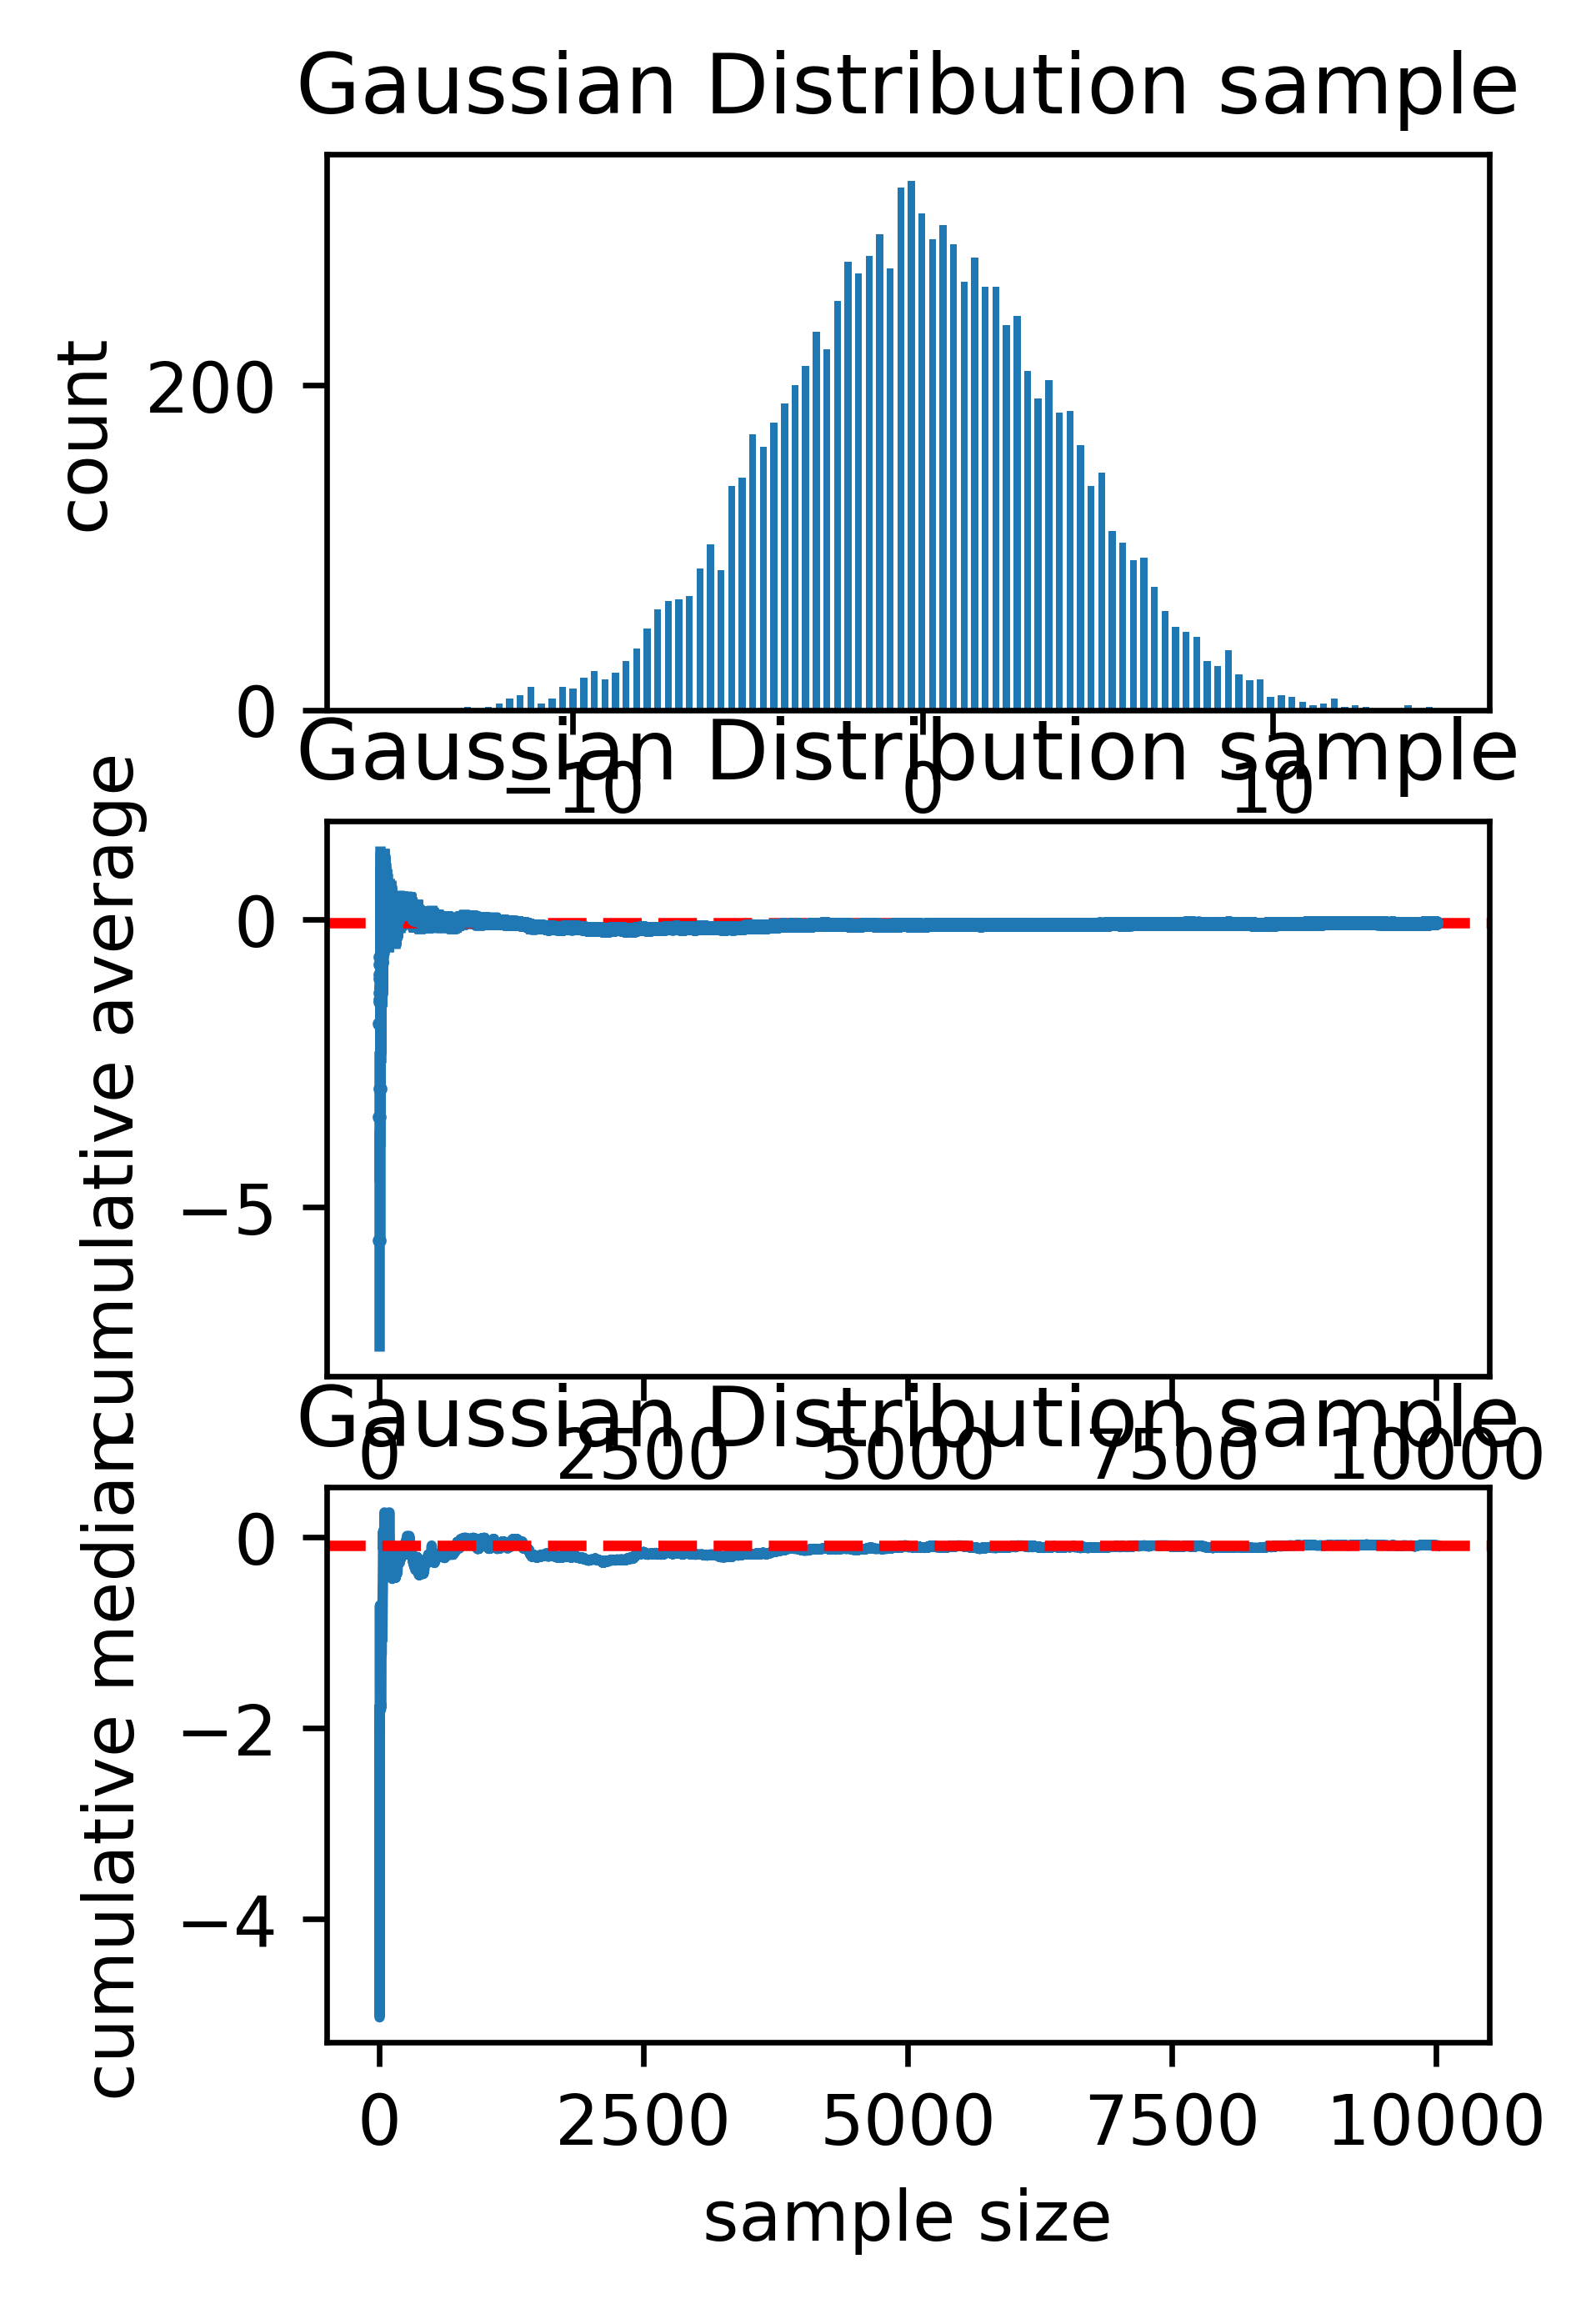

In [33]:
# 1. Sample N=10,000 data points from a Gaussian Distribution with parameters  𝜇=0  and  𝜎=4 ,
# using the np.random.standard_normal() function. Store your data in a numpy array 𝑋 .
mu = 0
sigma = 4
X = np.random.standard_normal(N) * sigma + mu

# DO points 2 to 8 for the Gaussian Distribution sample computed in point 9.
# collect them in a 1x3 grid of subplots.
fig, axs = plt.subplots(3, 1, figsize=(width, height), dpi=dpi)
axs = axs.flatten()

# plot distribution
axs[0].hist(X, bins=100, width=0.2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('count')
axs[0].set_title('Gaussian Distribution sample')

# cumulative average
cumulative_average = np.cumsum(X) / np.arange(1, N + 1)
cumulative_std = np.cumsum(X ** 2) / np.arange(1, N + 1) - cumulative_average ** 2
cumulative_std = np.sqrt(cumulative_std)
cumulative_std_error = cumulative_std / np.sqrt(np.arange(1, N + 1))

axs[1].errorbar(np.arange(1, N + 1), cumulative_average, yerr=cumulative_std_error, fmt='o', markersize=1)
axs[1].axhline(np.mean(X), color='r', linestyle='--')
axs[1].set_xlabel('sample size')
axs[1].set_ylabel('cumulative average')
axs[1].set_title('Gaussian Distribution sample')

# cumulative median
cumulative_median = np.zeros(N)
for i in range(N):
    cumulative_median[i] = np.median(X[:i + 1])

axs[2].plot(np.arange(1, N + 1), cumulative_median)
axs[2].axhline(np.median(X), color='r', linestyle='--')
axs[2].set_xlabel('sample size')
axs[2].set_ylabel('cumulative median')
axs[2].set_title('Gaussian Distribution sample')

Text(0.5, 1.0, 'Pareto Distribution')

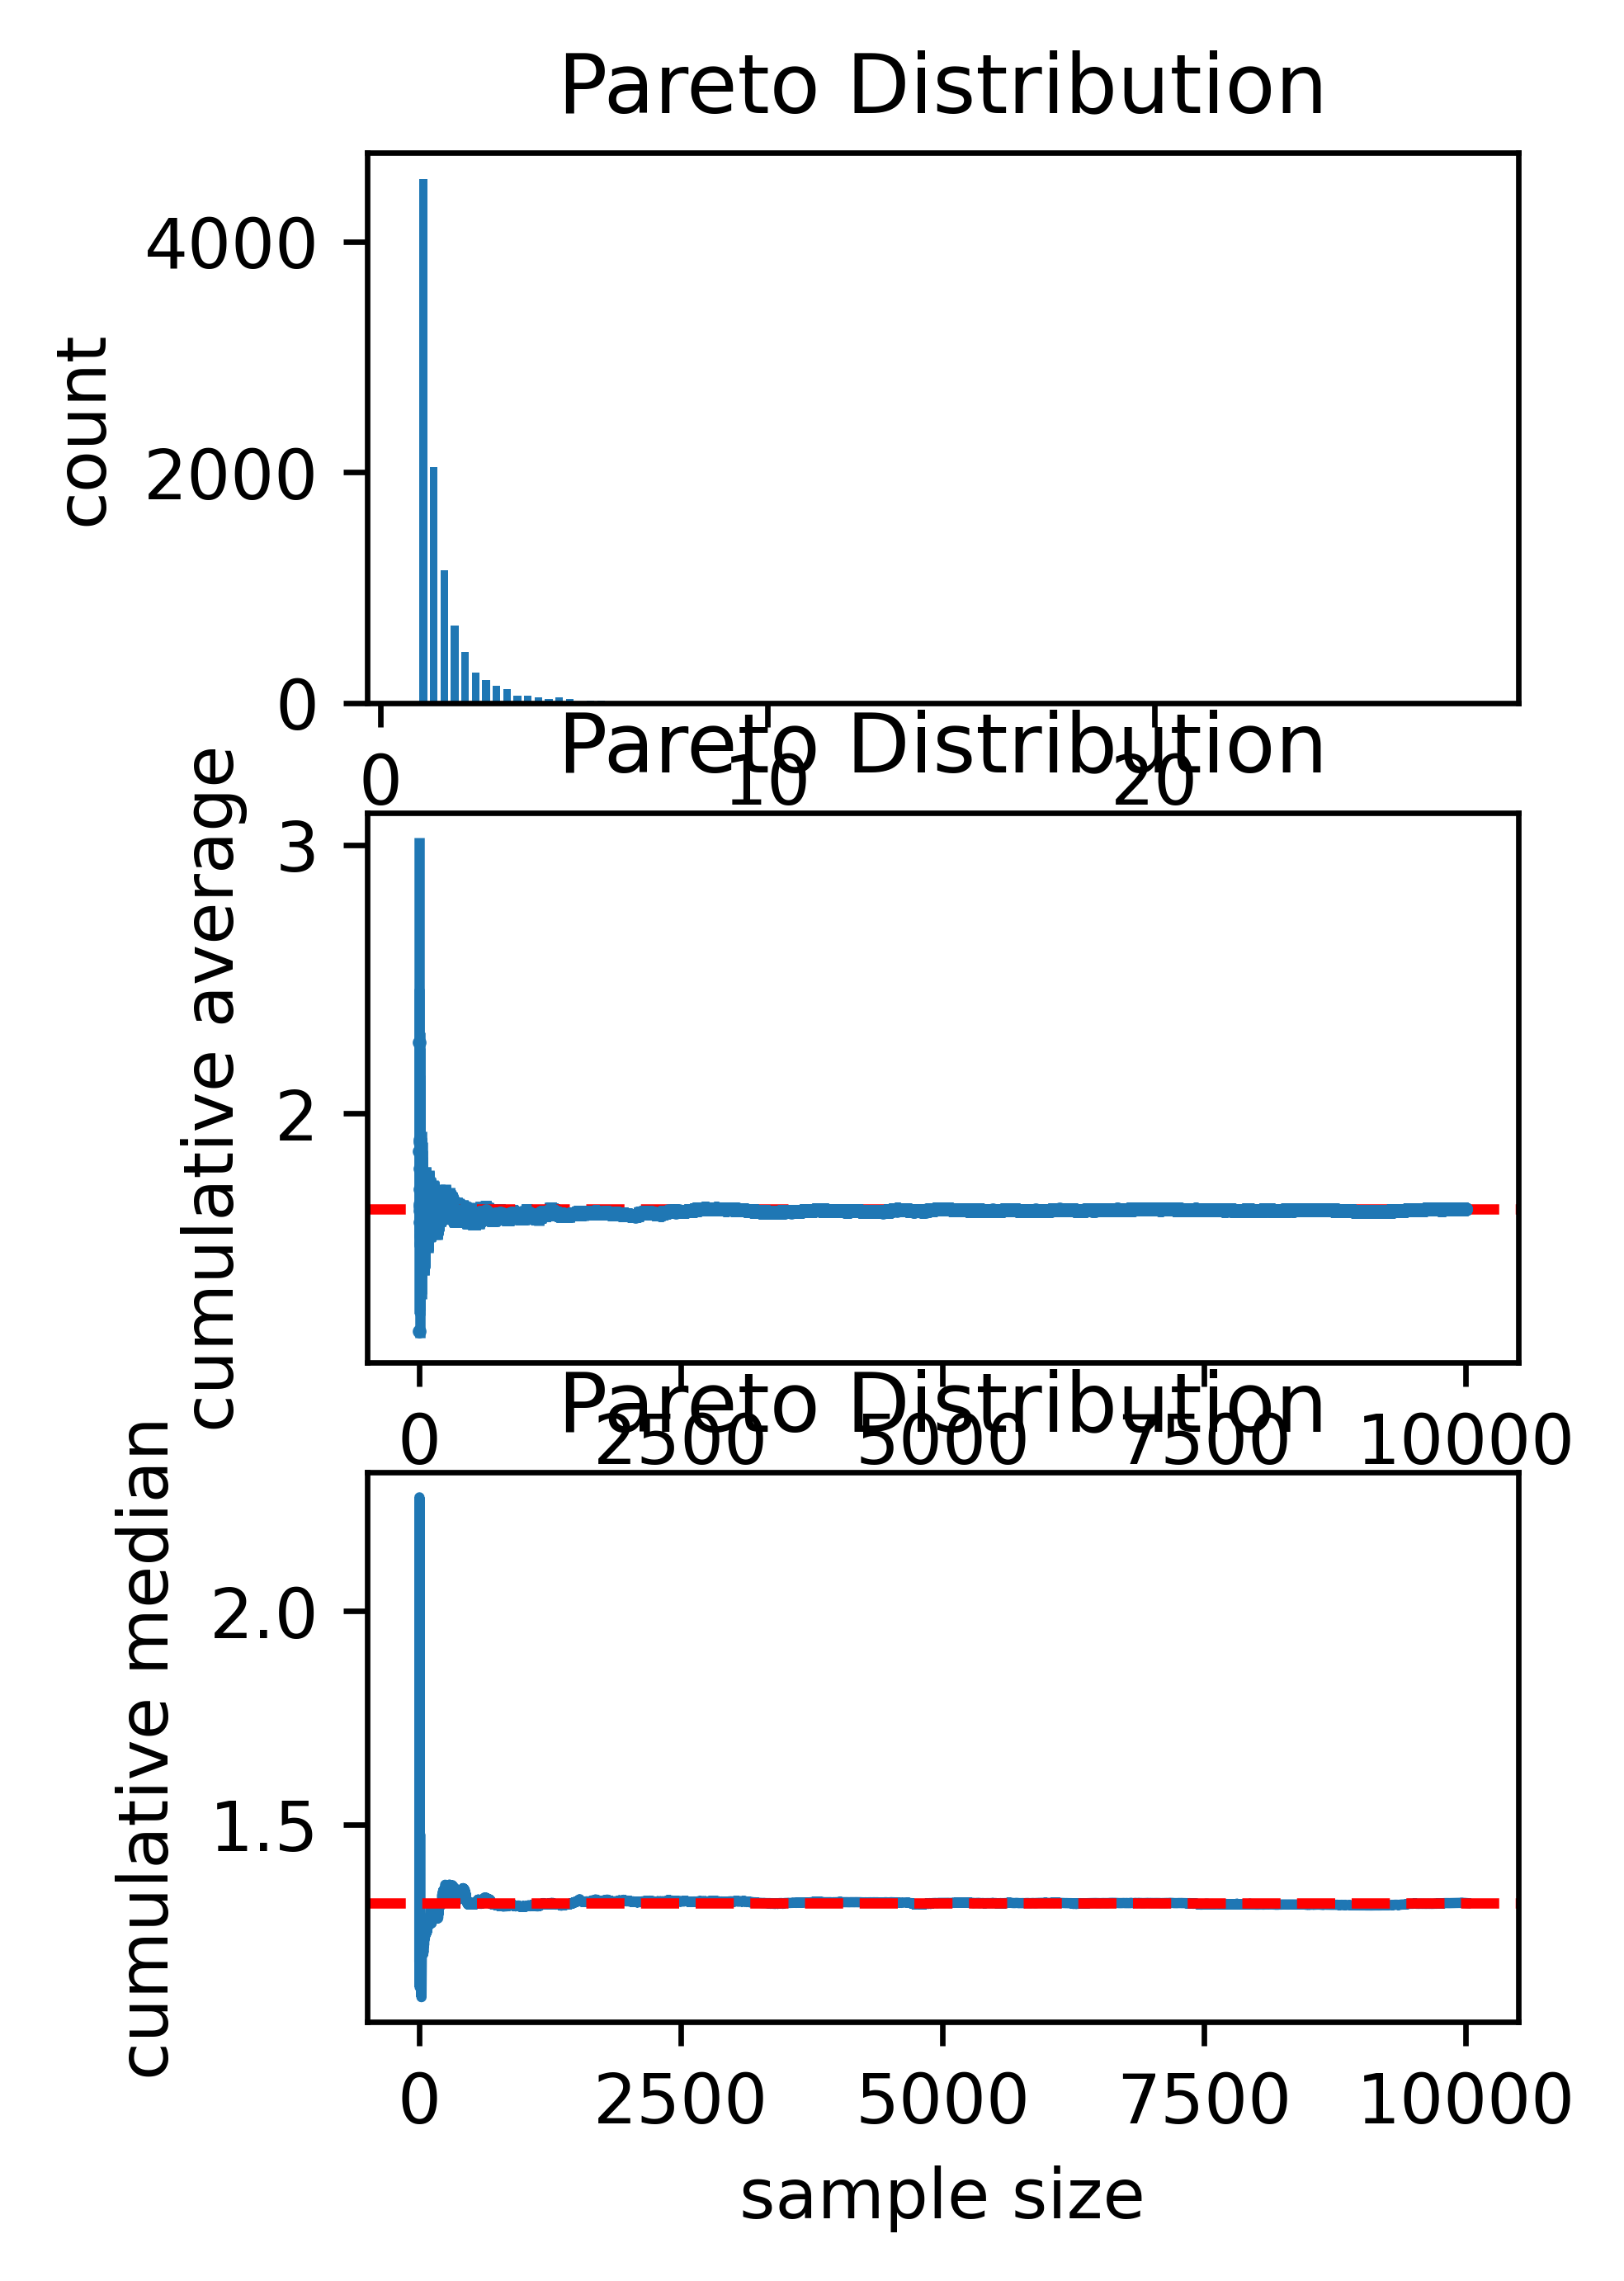

In [34]:
# 9. Now sample N=10,000 data points from a Pareto Distribution with parameters 𝑥𝑚=1 and 𝛼=2.5, using the np.random.pareto() function, and store it in a numpy array.
alpha = 2.5
xm = 1
X = np.random.pareto(alpha, N) + xm

# 10. Repeat points 2 to 8 for the Pareto Distribution sample computed in point 9.
# collect them in a 1x3 grid of subplots.
fig, axs = plt.subplots(3, 1, figsize=(width, height), dpi=dpi)
axs = axs.flatten()

# plot distribution
axs[0].hist(X, bins=100, width=0.2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('count')
axs[0].set_title('Pareto Distribution')

# cumulative average
cumulative_average = np.cumsum(X) / np.arange(1, N + 1)
cumulative_std = np.cumsum(X ** 2) / np.arange(1, N + 1) - cumulative_average ** 2
cumulative_std = np.sqrt(cumulative_std)
cumulative_std_error = cumulative_std / np.sqrt(np.arange(1, N + 1))

axs[1].errorbar(np.arange(1, N + 1), cumulative_average, yerr=cumulative_std_error, fmt='o', markersize=1)
axs[1].axhline(np.mean(X), color='r', linestyle='--')
axs[1].set_xlabel('sample size')
axs[1].set_ylabel('cumulative average')
axs[1].set_title('Pareto Distribution')

# cumulative median
cumulative_median = np.zeros(N)
for i in range(N):
    cumulative_median[i] = np.median(X[:i + 1])

axs[2].plot(np.arange(1, N + 1), cumulative_median)
axs[2].axhline(np.median(X), color='r', linestyle='--')
axs[2].set_xlabel('sample size')
axs[2].set_ylabel('cumulative median')
axs[2].set_title('Pareto Distribution')

Text(0.5, 1.0, 'Lognormal Distribution')

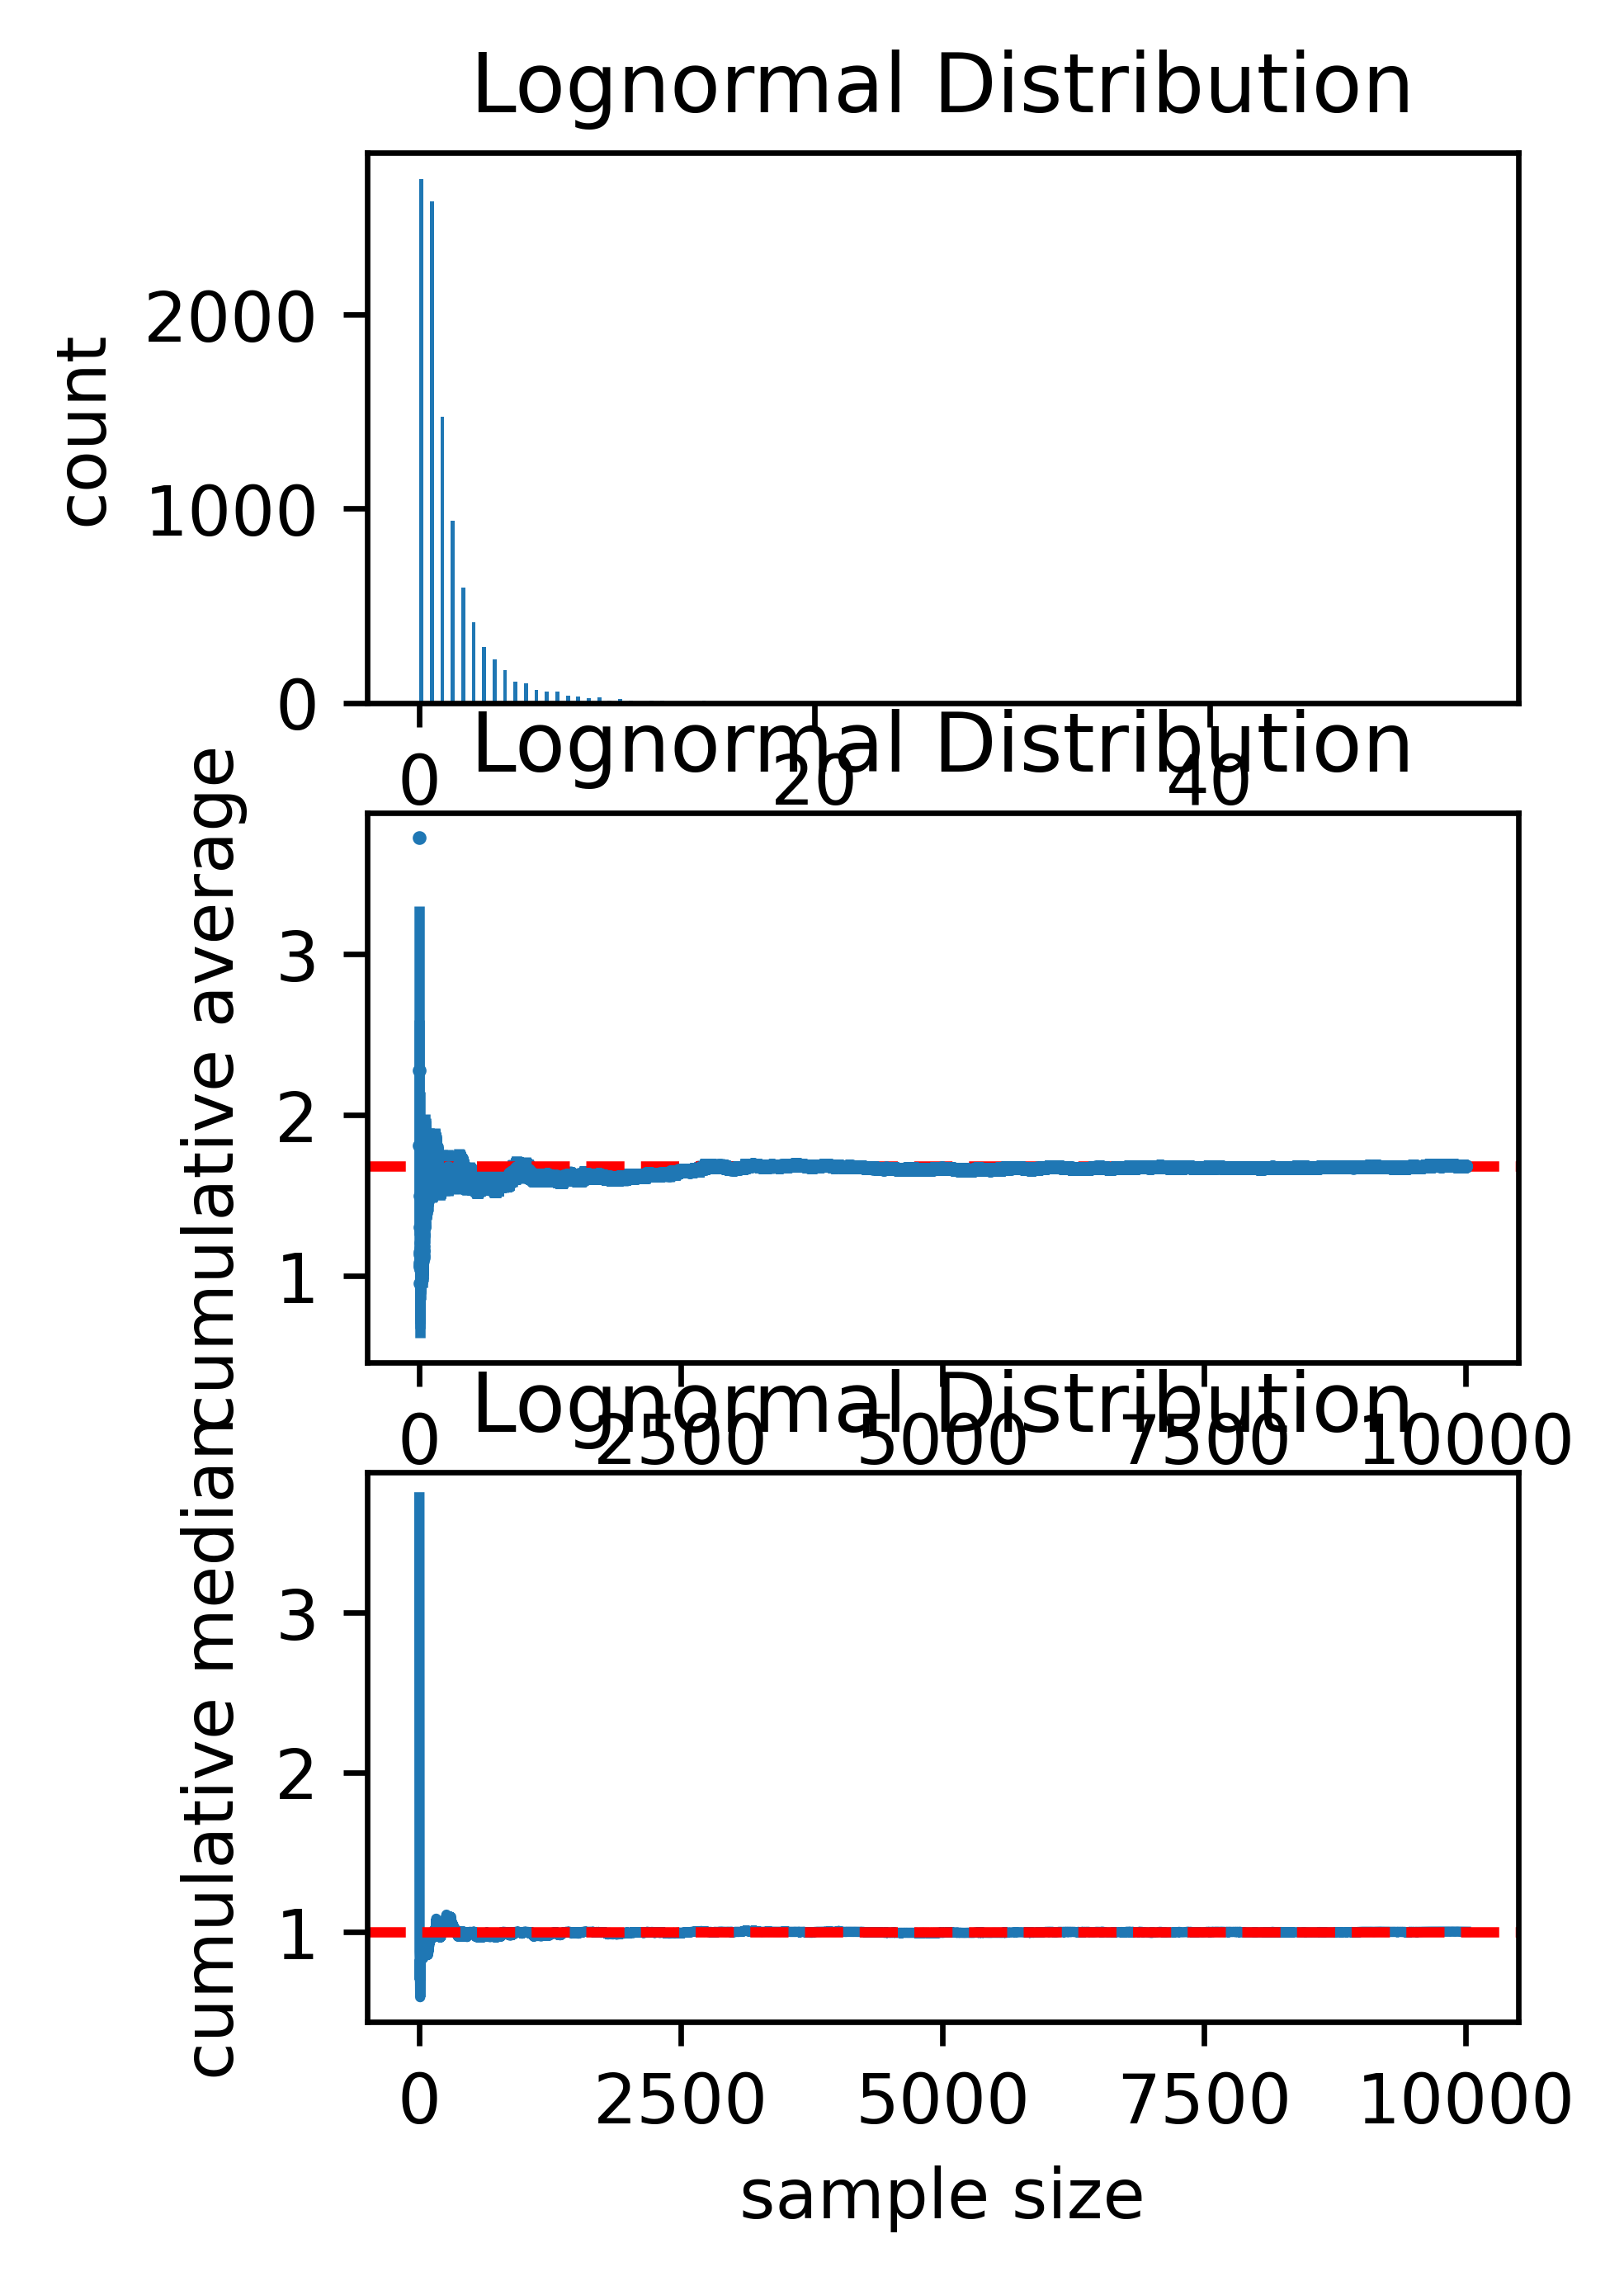

In [35]:
# 11. Now sample N=10,000 data points from a Lognormal Distribution with parameters 𝜇=0 and 𝜎=1, using the np.random.lognormal() function, and store it in a numpy array.

mu = 0
sigma = 1
X = np.random.lognormal(mu, sigma, N)

# 12. Repeat points 2 to 8 for the Lognormal Distribution sample computed in point 11.
# collect them in a 1x3 grid of subplots.
fig, axs = plt.subplots(3, 1, figsize=(width, height), dpi=dpi)
axs = axs.flatten()

# plot distribution
axs[0].hist(X, bins=100, width=0.2)
axs[0].set_xlabel('x')
axs[0].set_ylabel('count')
axs[0].set_title('Lognormal Distribution')

# cumulative average
cumulative_average = np.cumsum(X) / np.arange(1, N + 1)
cumulative_std = np.cumsum(X ** 2) / np.arange(1, N + 1) - cumulative_average ** 2
cumulative_std = np.sqrt(cumulative_std)
cumulative_std_error = cumulative_std / np.sqrt(np.arange(1, N + 1))

axs[1].errorbar(np.arange(1, N + 1), cumulative_average, yerr=cumulative_std_error, fmt='o', markersize=1)
axs[1].axhline(np.mean(X), color='r', linestyle='--')
axs[1].set_xlabel('sample size')
axs[1].set_ylabel('cumulative average')
axs[1].set_title('Lognormal Distribution')

# cumulative median
cumulative_median = np.zeros(N)
for i in range(N):
    cumulative_median[i] = np.median(X[:i + 1])

axs[2].plot(np.arange(1, N + 1), cumulative_median)
axs[2].axhline(np.median(X), color='r', linestyle='--')
axs[2].set_xlabel('sample size')
axs[2].set_ylabel('cumulative median')
axs[2].set_title('Lognormal Distribution')
